_This page is part of the material for the ["Introduction to Tensorflow"](https://indico.cism.ucl.ac.be/event/84/) session of the [2020 CISM/CÉCI trainings](http://www.ceci-hpc.be/training.html), see the [table of contents](index.html) for the other parts. The notebook can be downloaded with [this link](mlintro.ipynb)._
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pieterdavid/cism-mltf2020/blob/main/mlintro.ipynb)

> Machine learning is the study of computer algorithms that improve automatically through experience.

This is the first line of the [Machine learning](https://en.wikipedia.org/wiki/Machine_learning) wikipedia article, and it immediately gives some hints of the main ingredients of every machine learning solution.
The key point is that machine learning solutions do not use hard-coded instructions to solve a problem, but have some flexibility, and a strategy to take advantage of that to solve the task better.
It also naturally points us to the key ingredients of a machine learning solution:
- "experience": training data, which the algorithm can use to learn how to perform a task
- "improve": a way to measure the performance on the training data
- "automatically": a strategy to exploit the training data, without external input

A typical example of a machine learning task is classifying images (e.g. handwritten digits, pictures of objects...) with a neural network.
The neural network has a lot of free parameters, and the training sample is used to find values for these that assign the correct label as often as possible (we will get into the practicalities of that shortly).

Very often, machine learning is divided into the broad categories supervised learning, unsupervised learning, and reinforcement learning.
For this afternoon we will focus mostly on supervised learning, where the training dataset has a true answer for each example.
In unsupervised learning, no true answer is given, and the algorithm tries to find structure in the data.
Reinforcement learning, finally, means that the algorithm receives feedback from its environment, and tries to optimise that (typically examples are robot movements, or self-driving cars).

The focus of this session is on neural networks, but there are other types of machine learning algorithms (e.g. decision trees, support vector machines, genetic algorithms) which may be better or have practical advantages for some problems.
Very often it is possible to achieve equivalent performance with different techniques, and practical considerations (time needed to evaluate, to train, robustness etc.) will guide the choice for one of them.

## Neural networks

[Artificial neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network), often just called neural networks, are modeled somewhat after neurons in the brain: each neuron gets several inputs, and produces one output, mathematically: $x_i \mapsto y = f(x_i)$.
A typical neural network consists of many such nodes, with the input variables (which can be low-level, e.g. pixel intensities, or higher-level) passed to some nodes, the output nodes providing the neural network estimate (e.g. the probability to fall in a specific category, for a classification problem), and in between a number of hidden nodes.

A typical architecture arranges nodes in layers, where the inputs are the first layer, each layer getting inputs from all the outputs of the previous layer, the output nodes are the last layer, e.g.

![dense neural net](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Ann_dependency_%28graph%29.svg%2F320px-Ann_dependency_%28graph%29.svg.png)

Since each input is a number, the network above corresponds to the function $y = f(g_j(h_i(x))$ ($i=1,2,3$, $j=1,2$), so the functions of the consecutive neurons and layers are composed.

Many more architectures are possible (more layers, wider layers, sparse connections, bypasses etc.), but let's turn to some typical node functions now.
In principle any mathematical function would work, but it turns out that it is easier to work with large networks of simple nodes than small networks of complex node, so the common choice is
$$ f(x_i) = g(\sum_i a_i x_i + b) $$
where the $a_i$ paramaters are called the weights, $b$ the bias, and $g$ the activation function (typically a simple monotonous function).

Training the neural network is now a matter of finding the values of the weights and biases that perform best.
For supervised learning problems, this is done with a loss function that measures how close the outputs are on average to the target values (true labels), or how efficient the network is at categorizing.
Then the training needs to minimize the loss function over the training sample by adjusting the parameter values.
This will be done by calculating the loss function with respect to the weights and biases, and changing them in the direction that decreases the loss, until it is close to the miminal value.

## A first example

Now we have all the ingredients needed for a small example: training a neural network to approximate a one-dimensional function, a part of the sine function.


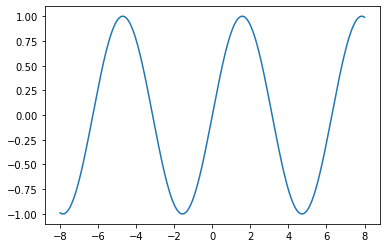

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
x0 = tf.linspace(-8., 8., 2048)
plt.plot(x0, tf.sin(x0))

First we need a training sample, which can be any points along the curve, so we may as well take the uniform sampling from above (the `linspace` and `sin` functions are used instead of their numpy counterparts to save a few lines below, nothing special is ongoing yet), randomly shuffled and with a bit of noise.

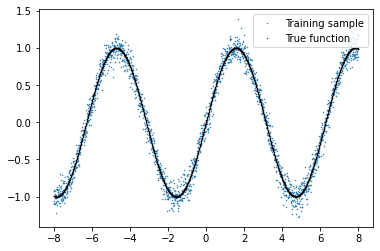

In [2]:
x_learning = tf.reshape(tf.random.shuffle(x0), (2048, 1))
y_learning = ( tf.sin(x_learning)
              + tf.random.normal(x_learning.shape)*.1 )
plt.plot(x_learning, y_learning, "o", ms=.5,
         label="Training sample")
plt.plot(x_learning, tf.sin(x_learning), "k.", ms=.7,
         label="True function")
plt.legend()

We will use a very simple architecture, with a first hidden layer of 128 nodes that uses the relu activation function, which is zero if $x$ is negative and $x$ if $x$ is positive, and then a sigmoid, which smoothly maps onto the range from zero to one, so we will change that to minus one to one with $s \to 2s-1$.

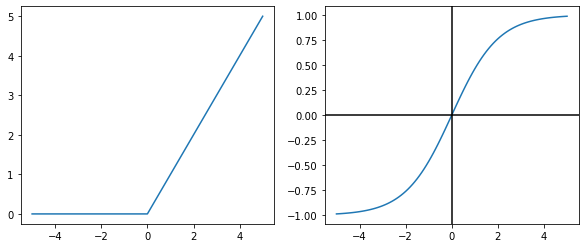

In [3]:
x_demo = tf.linspace(-5., 5., 101)
fig,ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(x_demo, tf.nn.relu(x_demo))
ax[1].plot(x_demo, 2*tf.math.sigmoid(x_demo)-1)
ax[1].axhline(0., c="k")
ax[1].axvline(0., c="k")

Tensorflow has ready-made classes for layers of nodes with all the weights and biases, so we will use these (`Dense` means that all inputs and outputs are connected, so there is a $n_{in}\times n_{out}$ weights matrix).

In [4]:
l1 = tf.keras.layers.Dense(128, activation="relu",
                           bias_initializer="glorot_uniform")
l2 = tf.keras.layers.Dense(1, activation="sigmoid")
def nn1(xi):
    return 2.2*l2(l1(.1*xi))-1.1

`bias_initializer="glorot_uniform"` will also initialise the biases with random values; normally this is only done for the weights, and here it really helps (it will help the different nodes to look at different pieces of the curve).
There are two other little trick used here: since the sigmoid will only asymptotically tend to 1, we scale it by 1.1, such that it can reach the extreme values of the sine function, and we scale the inputs by a factor ten such that they are of the order 1.

In [5]:
x_learn_batches = tf.split(x_learning, num_or_size_splits=64)
y_learn_batches = tf.split(y_learning, num_or_size_splits=64)
loss_history = []
for i in range(250):
    epochLoss = 0.
    for x_b, y_t_b in zip(x_learn_batches, y_learn_batches):
        with tf.GradientTape() as tape:
          loss = tf.reduce_mean((nn1(x_b)-y_t_b)**2)
        epochLoss += loss
        trainable = ( l1.trainable_variables
                     + l2.trainable_variables )
        gradients = tape.gradient(loss, trainable)
        for iTr,iGr in zip(trainable, gradients):
            iTr.assign_sub(.085*iGr)
    loss_history.append(epochLoss)
    if (i+1) % 10 == 0:
        print(f"Epoch {i:d} loss value: {epochLoss}")

Epoch 9 loss value: 31.754419326782227
Epoch 19 loss value: 29.28603172302246
Epoch 29 loss value: 24.79075813293457
Epoch 39 loss value: 19.495380401611328
Epoch 49 loss value: 13.88448429107666
Epoch 59 loss value: 8.705987930297852
Epoch 69 loss value: 5.16720724105835
Epoch 79 loss value: 3.1924474239349365
Epoch 89 loss value: 2.1461286544799805
Epoch 99 loss value: 1.5797522068023682
Epoch 109 loss value: 1.2617838382720947
Epoch 119 loss value: 1.075917363166809
Epoch 129 loss value: 0.9641549587249756
Epoch 139 loss value: 0.8947022557258606
Epoch 149 loss value: 0.8504143357276917
Epoch 159 loss value: 0.8218280673027039
Epoch 169 loss value: 0.8030276894569397
Epoch 179 loss value: 0.7903864979743958
Epoch 189 loss value: 0.7819594144821167
Epoch 199 loss value: 0.7761822938919067
Epoch 209 loss value: 0.7721703052520752
Epoch 219 loss value: 0.7693469524383545
Epoch 229 loss value: 0.7673658132553101
Epoch 239 loss value: 0.7658758163452148
Epoch 249 loss value: 0.7648036479

This one will raise a bit more questions, but the principle is straightforward: we split the data in "batches" of 128 entries, and loop a hundred times over all batches of input data, and keep a list of the total loss over each such "epoch".
Then for each batch we calculate the loss (`tf.reduce_mean` calculates the sum and divides by the number of entries - that is a fixed number here, so it does not matter much), and the derivatives of the loss with respect to the weights and biases (that is what the `GradientTape` is for, we will look into more detail at that later).
After each batch, we change all the parameters by small step, in the direction that decreases the loss — more on that in a minute, first we have a look how it performed:

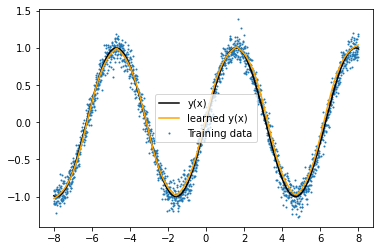

In [6]:
plt.scatter(x_learning, y_learning, label="Training data", s=1)
plt.plot(x0, tf.sin(x0), label="y(x)", color="k")
plt.plot(x0, nn1(tf.reshape(x0, (2048,1))),
         label="learned y(x)", color="orange")
plt.legend()

That is not so bad for a first attempt.
Some small differences are visible at the ends, so this is clearly not perfect (and not something one would need to do in practice), but it is a nice demonstration how a nontrivial functional dependence can be learned from data.

This example, however trivial and artificial, points to many interesting things to look at next:
- the loss function: for this regression problem we used a simple mean square error (or $\chi^2$) loss function
$$
\sum_i (y_i - f(x_i))^2
$$
  which clearly will have its miminum when $f(x_i) = y_i$ for all elements of the training sample.
  It is common for function regression, we will look at some other loss functions (e.g. for classification) in the next examples.
  In principle this can be anything that depends on the data and parameters, so it can also be used to add e.g. a cost for large weight values, to try and get a better-behaved network (regularization).
- also, many different types of network architectures exist, which we will look into later.

## More about learning

But first we will look at the learning process in a bit more detail.
The strategy used above to find the neural network parameter values that minimise the loss function is called [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

![gradient descent](https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif)

The [gradient](https://en.wikipedia.org/wiki/Gradient) is the direction of steepest increase of a function, so the gradient of the loss function with respect to the parameter values tells us which combination of steps will increase it fastests.
The direction of fastest decrease is just the opposite, which explains the `assign_sub` call (subtract a small step along the gradient from the parameter value).

If we were to calculate the gradient on the whole dataset, we would be using gradient descent minimisation.
*Stochastic* (random, or with some random ingredients) refers to the fact that we use a small batch, randomly chosen, batch of data, only.
This is faster, and the fact that the gradient changes a bit from batch to batch can actually help to avoid being trapped in a local minimum (as the rightmost point in the animation above); our loss function will depend on 385 variables, so its shape may be quite complex with lots of local minima, but we want to find the global minimum.

Looking at this as a minimisation problem, there are more refined methods to quickly find the minimum of a function with a low number of parameters, but they often require more complex calculations with the gradients (or second-order derivatives).
The advantage of stochastic gradient is the speed, and the fact that it handles large numbers of parameters very well.
It is very common in (deep) learning, often with some variations or extensions, e.g. a scheme for adapting the step size throughout the learning process, instead of using a fixed value.

Since we kept the values of the training set loss of each iteration, we can look at how it evolved:

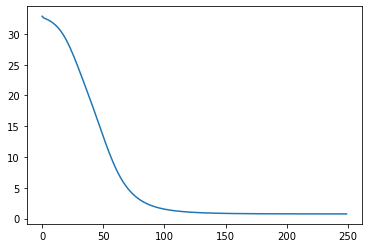

In [7]:
plt.plot(loss_history)

This is a rather common picture: at first the weights are random, so the loss function is quite high, after some iterations (one loop over the whole dataset is called an *epoch*) it starts to learn more quickly, and as it nears the minimum, that slows down, to flatten out eventually.

Even if we train for a very long time, we will not reach a zero value for the loss function.
Primarily because the network has limited *capacity* (and non-linearity) to fit the data perfectly, but also because of the minimisation strategy, the training dataset being finite, and the noise we added.

The effect of the last one is easy to calculate:

In [8]:
print("Loss from noise: {0}".format(
    sum(tf.reduce_mean(y_b-tf.sin(x_b))**2
        for x_b, y_b in zip(x_learn_batches, y_learn_batches))))

Loss from noise: 0.024055151268839836


We are clearly still a long way from that, but if our training sample would be smaller, or our network much bigger (more layers, more nodes; the *capacity* of the network is the complexity it is able to represent), it might actually adapt to more specific features of the training sample than the smooth function used to generate it, because in a finite sample, there will be some random over- and underdensities of points.
This phenomenon is called *overtraining*, and the opposite, where the network does not have enough capacity to learn the true function or distribution, *undertraining*.

![overfitting](https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/240px-Overfitting.svg.png)

We would like the neural network to learn exactly the true distribution, such that it *generalizes* from our training sample to any other sample drawn from the same distribution, but that requires to find a good balance between the training sample, network architecture, and training process.
There are several strategies to try and prevent mitigate overfitting (this is called *regularization*):
- L1 and L2 regularization add a penalty term to the loss function, which is the sum of absolute values of all the weights (L1), or the sum of the squares of the weights (L2). They can be applied to all or some layers.
- dropout regularization randomly sets the inputs to some nodes (typically 50%, for one or more of the hidden layers) to zero during training. It reduces the capacity of the network and makes training slower, but it will make the subsequent nodes "see" a more diverse input sample, and make it less rewarding to learn small coincidences rather than the main features of the training sample

A simple, and very common, way to check for overfitting, is to not use a (randomly selected) part of the training sample, but keep it as a validation sample: by construction they are from the same distribution that the network should learn, so if the performance is significantly different between the one used for training and the validation sample, that is an indication of overtraining.
One check is to calculate the value of the loss on the validation sample after every epoch of the training.
The typical pattern that arises then is that the training and validation loss follow the same trend at first, and after training for a sufficiently long time the "validation loss" stays at the same value, or even goes up, while the training loss keeps decreasing; the training should obviously be stopped before.

The disadvantage of a validation sample is that some data is lost for training.
A possible way around that is [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29), where the sample is split in different parts, and a training is done with each of the parts left out, as a validation sample; if that does not show any problems, the different estimators can be averaged.

## Classification problems

When we turn from *regression* (estimating the value(s) of a function, given the inputs) to *classification*, we will need to change a few things.
One is the output layer: there is now one output per category.
It is common (and convenient) to make sure the outputs are positive by transforming them with $x\mapsto e^x$, and to make sure they add up to one:
$$
x_i \mapsto \frac{e^{x_i}}{\sum_{j=1}^\text{nodes} e^x_j}
$$
then the outputs can be interpreted as the (estimated) probability for an entry to fall in one of the categories.
The true labels of the training sample will then be, for each entry, zero for the wrong, and one for the correct node.

As a loss function, the standard choice is the categorical cross-entropy
$$
-\sum_{j=1}^\text{nodes} y_j \ln{f_j(x)}
$$
with $y_j$ the true labels, and $f_j(x)$ the output of the $j$-th node (which is summed over all entries of the training sample).
As above, $y_j$ will be zero for the wrong and one for the correct category, then a small estimated probabiliy for that category will give a large contribution to the loss function.
[Cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) is a concept from information theory, it gives a measure of the divergence between the true distributions over the categories and the distributions estimated by the neural network.
An interesting mathematical property is that minimizing the cross-entropy is [equivalent](https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_log-likelihood) to maximizing the likelihood.

A fun thing to play with to get a feeling for how the training works is the [playground](https://playground.tensorflow.org) inside the browser.
You can design your own neural network to solve a two-dimensional categorization problem.